In [2]:
from datasets import load_dataset

ds = load_dataset("yelp_review_full")

print(ds["train"][0])


d:\Sentiment Analysis YELP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}


In [3]:
import string
import re

In [4]:
import re
def remove_special_chars(text) :
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

In [5]:
ds = ds.map(lambda x: {"text": remove_special_chars(x["text"]), "label": x["label"]}) 

In [6]:
from transformers import AutoTokenizer

model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", truncation = True)

In [7]:
tokenized_ds = ds.map(tokenize_function, batched= True)
tokenized_ds = tokenized_ds.remove_columns(["text"])
tokenized_ds = tokenized_ds.rename_column("label", "labels")
tokenized_ds.set_format("torch")

In [8]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model_sa = AutoModelForSequenceClassification.from_pretrained(model, num_labels= 5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np 
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir = "./results",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
    num_train_epochs = 4,
    weight_decay = .01,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    fp16= True
)

def compute_metrics(pred):
    logits, labels = pred
    return {"accuracy": accuracy_score(labels, np.argmax(logits, axis=1))}

trainer = Trainer(
    model = model_sa,
    args = training_args,
    train_dataset = tokenized_ds["train"].shuffle(seed= 42).select(range(30000)),
    eval_dataset = tokenized_ds["test"].select(range(10000)),
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

d:\Sentiment Analysis YELP\.venv\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\berku\AppData\Local\Temp\ipykernel_25888\2722359166.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
import torch
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


Torch version: 2.5.1+cu121
CUDA version: 12.1
CUDA available: True
Device: NVIDIA GeForce RTX 3050 Laptop GPU


In [11]:
trainer.train()
trainer.save_model("yelp_sentiiment_analysis")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.930772,0.586500
2,1.029200,0.891784,0.609100
3,0.830500,0.901812,0.613000
4,0.733600,0.925572,0.612200


In [12]:
trainer.evaluate()

{'eval_loss': 0.9018120169639587,
 'eval_accuracy': 0.613,
 'eval_runtime': 71.475,
 'eval_samples_per_second': 139.909,
 'eval_steps_per_second': 2.197,
 'epoch': 4.0}

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve,auc
from sklearn.preprocessing import label_binarize

In [17]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer

In [19]:
test_subset = tokenized_ds["test"].select(range(10000))

true_labels = []
pred_labels = []
logits = []

model_sa.eval()
for batch in torch.utils.data.DataLoader(test_subset, batch_size= 64):
    input_ids = batch["input_ids"].to(model_sa.device)
    attention_mask = batch["attention_mask"].to(model_sa.device)
    labels = batch["labels"].to(model_sa.device)

    with torch.no_grad():
        outputs = model_sa(input_ids= input_ids, attention_mask=attention_mask, labels= labels)
    
    logits.extend(outputs.logits.cpu().numpy())
    true_labels.extend(batch["labels"].numpy())
    pred_labels.extend(np.argmax(outputs.logits.cpu().numpy(), axis= 1))

y_true = np.array(true_labels)
y_pred = np.array(pred_labels)
logits = np.concatenate(logits, axis= 0)

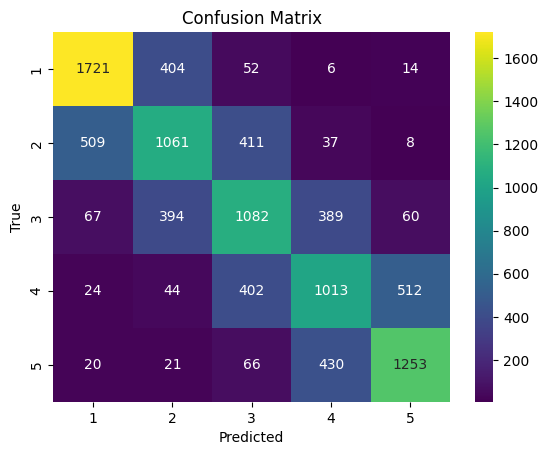

In [22]:
import seaborn as sns
cm = confusion_matrix(y_true= y_true, y_pred= y_pred)
sns.heatmap(cm, annot= True, fmt = "d", cmap = "viridis", xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

After reshaping:
y_true_bin shape: (10000, 5)
logits shape: (10000, 5)


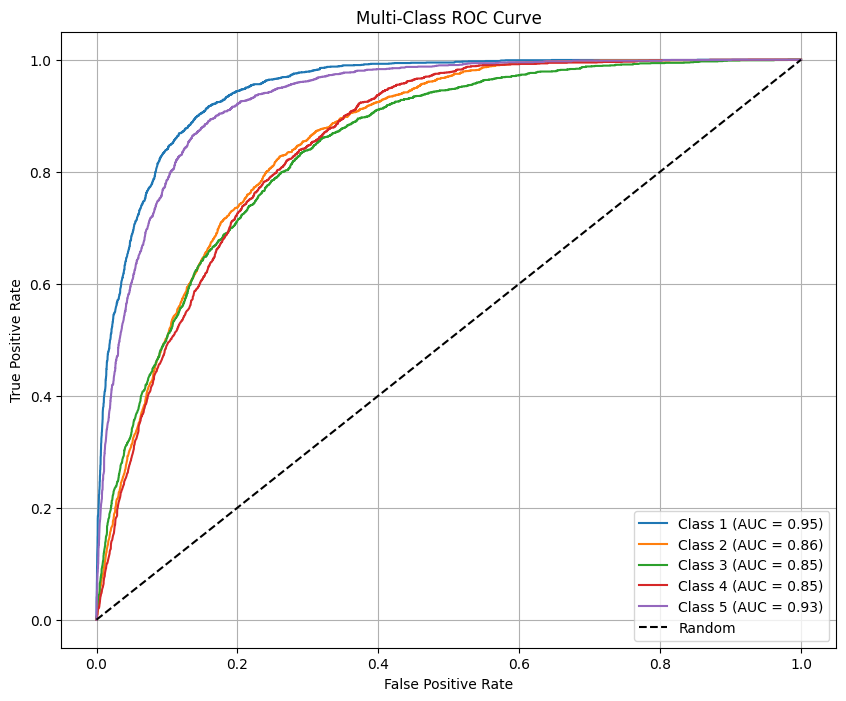

In [28]:
y_true_bin = label_binarize(y_true, classes=[0,1,2,3,4])
logits = logits.reshape(-1, 5)

print("After reshaping:")
print("y_true_bin shape:", y_true_bin.shape)
print("logits shape:", logits.shape)

plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], logits[:, i])
    auc = roc_auc_score(y_true_bin[:, i], logits[:, i])
    plt.plot(fpr, tpr, label=f"Class {i+1} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
import pandas as pd
print(pd.DataFrame(classification_report(y_true, y_pred, output_dict= True)))

                     0            1            2            3            4  \
precision     0.735156     0.551455     0.537506     0.540267     0.678397   
recall        0.783341     0.523692     0.543173     0.507769     0.700000   
f1-score      0.758484     0.537215     0.540325     0.523514     0.689029   
support    2197.000000  2026.000000  1992.000000  1995.000000  1790.000000   

           accuracy     macro avg  weighted avg  
precision     0.613      0.608556      0.609526  
recall        0.613      0.611595      0.613000  
f1-score      0.613      0.609713      0.610889  
support       0.613  10000.000000  10000.000000  


In [40]:
model_sa.save_pretrained("yelp_sentiment_multiclass_model")
tokenizer.save_pretrained("yelp_sentiment_multiclass_tokenizer")

('yelp_sentiment_multiclass_tokenizer\\tokenizer_config.json',
 'yelp_sentiment_multiclass_tokenizer\\special_tokens_map.json',
 'yelp_sentiment_multiclass_tokenizer\\vocab.txt',
 'yelp_sentiment_multiclass_tokenizer\\added_tokens.json',
 'yelp_sentiment_multiclass_tokenizer\\tokenizer.json')

In [38]:
model_sa.save_pretrained("model_sa", safe_serialization= False)

In [43]:
from huggingface_hub import create_repo, upload_folder

create_repo("yelp-sentiment-star-prediction", private= False)

upload_folder(folder_path= "D:\Sentiment Analysis YELP\yelp_sentiment_multiclass_model",
              path_in_repo="",
              repo_id="berkutayozdemir/yelp-sentiment-star-prediction")

<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
C:\Users\berku\AppData\Local\Temp\ipykernel_25888\613045571.py:5: SyntaxWarning: invalid escape sequence '\S'
  upload_folder(folder_path= "D:\Sentiment Analysis YELP\yelp_sentiment_multiclass_model",
pytorch_model.bin: 100%|██████████| 268M/268M [02:12<00:00, 2.02MB/s] 


CommitInfo(commit_url='https://huggingface.co/berkutayozdemir/yelp-sentiment-star-prediction/commit/edf48bcd8951b576d22004f8cd09b2a744dca682', commit_message='Upload folder using huggingface_hub', commit_description='', oid='edf48bcd8951b576d22004f8cd09b2a744dca682', pr_url=None, repo_url=RepoUrl('https://huggingface.co/berkutayozdemir/yelp-sentiment-star-prediction', endpoint='https://huggingface.co', repo_type='model', repo_id='berkutayozdemir/yelp-sentiment-star-prediction'), pr_revision=None, pr_num=None)

In [44]:
upload_folder(folder_path="D:\Sentiment Analysis YELP\yelp_sentiment_multiclass_tokenizer",
              path_in_repo = "",
              repo_id="berkutayozdemir/yelp-sentiment-star-prediction")

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\berku\AppData\Local\Temp\ipykernel_25888\163585315.py:1: SyntaxWarning: invalid escape sequence '\S'
  upload_folder(folder_path="D:\Sentiment Analysis YELP\yelp_sentiment_multiclass_tokenizer",


CommitInfo(commit_url='https://huggingface.co/berkutayozdemir/yelp-sentiment-star-prediction/commit/25635ae5c56c4b2fd7be0913b6f208d9c2e3b2e1', commit_message='Upload folder using huggingface_hub', commit_description='', oid='25635ae5c56c4b2fd7be0913b6f208d9c2e3b2e1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/berkutayozdemir/yelp-sentiment-star-prediction', endpoint='https://huggingface.co', repo_type='model', repo_id='berkutayozdemir/yelp-sentiment-star-prediction'), pr_revision=None, pr_num=None)